# Softmax benchmark comparison

In [3]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

def softmax_scratch(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def softmax_torch(x):
    # x: Tensor of shape (batch_size, num_classes)
    x_max = torch.max(x, dim=1, keepdim=True).values
    e_x = torch.exp(x - x_max)
    return e_x / torch.sum(e_x, dim=1, keepdim=True)

def softmax_builtin(x, dim=1):
    return F.softmax(x, dim=dim)

Conduct test to compare the three implementations of softmax

In [4]:
# Test with different batch sizes
batch_sizes = [1000, 10000, 100000, 1000000]
num_classes = 1000  # Fixed number of classes

# Store timing results
numpy_times = []
torch_manual_times = []
torch_builtin_times = []

for batch_size in batch_sizes:
    # Create random data
    np_data = np.random.randn(batch_size, num_classes)
    # torch_data = torch.tensor(np_data, dtype=torch.float32)
    torch_data = torch.tensor(np_data, dtype=torch.float32).cuda()  # Move to GPU if available
    
    # Benchmark NumPy implementation
    start = time.time()
    softmax_scratch(np_data)
    numpy_times.append(time.time() - start)
    
    # Benchmark manual PyTorch implementation
    start = time.time()
    softmax_torch(torch_data)
    torch_manual_times.append(time.time() - start)
    
    # Benchmark PyTorch built-in implementation
    start = time.time()
    softmax_builtin(torch_data)
    torch_builtin_times.append(time.time() - start)

Plot results

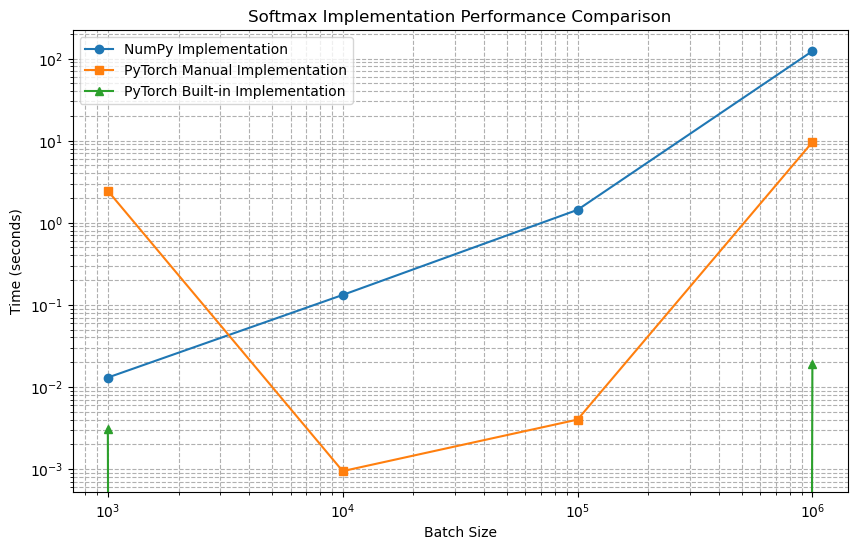

Batch Sizes: [1000, 10000, 100000, 1000000]
NumPy Implementation (seconds): ['0.012997', '0.131819', '1.433910', '122.997584']
PyTorch Manual Implementation (seconds): ['2.443730', '0.000942', '0.003998', '9.582413']
PyTorch Built-in Implementation (seconds): ['0.003073', '0.000000', '0.000000', '0.019006']

Speedup Ratios:
NumPy vs PyTorch Built-in: ['4.23x', 'infx', 'infx', '6471.51x']
Manual PyTorch vs Built-in: ['795.11x', 'infx', 'infx', '504.18x']


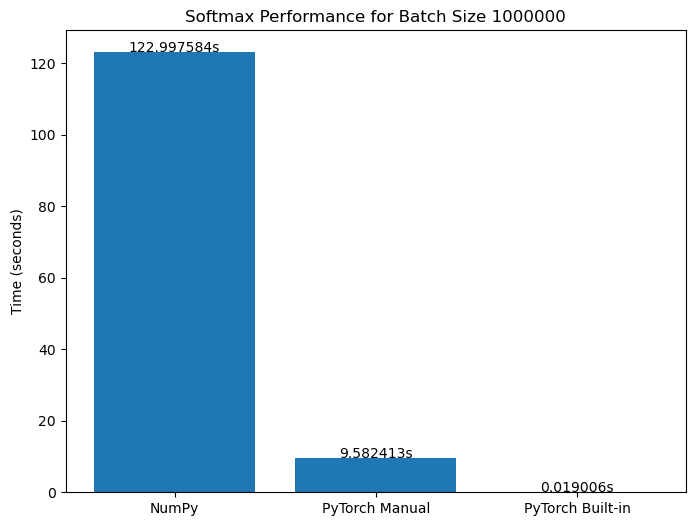

In [7]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, numpy_times, 'o-', label='NumPy Implementation')
plt.plot(batch_sizes, torch_manual_times, 's-', label='PyTorch Manual Implementation')
plt.plot(batch_sizes, torch_builtin_times, '^-', label='PyTorch Built-in Implementation')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Softmax Implementation Performance Comparison')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig(os.path.join('figs', 'softmax_benchmark.png'))
plt.show()

# Print the actual timing values
print("Batch Sizes:", batch_sizes)
print("NumPy Implementation (seconds):", [f"{t:.6f}" for t in numpy_times])
print("PyTorch Manual Implementation (seconds):", [f"{t:.6f}" for t in torch_manual_times])
print("PyTorch Built-in Implementation (seconds):", [f"{t:.6f}" for t in torch_builtin_times])

# Calculate speedup ratios
# numpy_to_torch_builtin = [n/t for n, t in zip(numpy_times, torch_builtin_times)]
numpy_to_torch_builtin = [n/t if t > 0 else np.inf for n, t in zip(numpy_times, torch_builtin_times)]
# manual_to_builtin = [m/b for m, b in zip(torch_manual_times, torch_builtin_times)]
manual_to_builtin = [m/b if b > 0 else np.inf for m, b in zip(torch_manual_times, torch_builtin_times)]

print("\nSpeedup Ratios:")
print("NumPy vs PyTorch Built-in:", [f"{r:.2f}x" for r in numpy_to_torch_builtin])
print("Manual PyTorch vs Built-in:", [f"{r:.2f}x" for r in manual_to_builtin])

# Create a bar chart for the largest batch size
plt.figure(figsize=(8, 6))
labels = ['NumPy', 'PyTorch Manual', 'PyTorch Built-in']
times = [numpy_times[-1], torch_manual_times[-1], torch_builtin_times[-1]]
plt.bar(labels, times)
plt.ylabel('Time (seconds)')
plt.title(f'Softmax Performance for Batch Size {batch_sizes[-1]}')
for i, v in enumerate(times):
    plt.text(i, v + 0.0001, f"{v:.6f}s", ha='center')
plt.savefig(os.path.join('figs', 'softmax_largest_batch.png'))
plt.show()